In [1]:
import keras
from keras import backend as K
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, ELU, Permute, TimeDistributed
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, MaxPool2D
from keras.layers import Input, LSTM, RepeatVector, Lambda,Bidirectional,CuDNNLSTM
from keras import regularizers
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import objectives
import numpy as np
import matplotlib.pyplot as plt
import time
from keras.regularizers import l2
from keras import layers, models
from keras.regularizers import L1L2

Using TensorFlow backend.


In [2]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [3]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [4]:
y_train_valid -= 769
y_test = y_test-769

In [5]:
def crnn(input_shape):
    model = Sequential()

    model.add(Conv2D(16, kernel_size=(1, 10), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01), input_shape=input_shape, data_format='channels_last'))
    model.add(ELU())
    model.add(BatchNormalization())

    model.add(Conv2D(32, kernel_size=(21, 1), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization())
    model.add(MaxPool2D((1, 4)))
        
    model.add(Conv2D(64, kernel_size=(1, 10), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization())
    model.add(MaxPool2D((1, 4)))
    model.add(Dropout(0.4))
    
    model.add(Permute((2, 3, 1)))
    model.add(TimeDistributed(Flatten()))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(32)))#reduce dims from 3 to 2// could use Flatten() instead
    model.add(Dropout(0.4))
    model.add(Dense(4, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='softmax'))
    opt = keras.optimizers.Adam(lr=0.005, epsilon=1e-8, decay=0.01)
    model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['acc'])
    
    return model

In [6]:
def train(model, x_train, y_train, x_test, y_test):
    history = model.fit(x_train,y_train,batch_size=50,epochs=200,shuffle=True,validation_split = 0.2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return model

In [7]:
def predict(model,x_test,y_test):
    y_pred = model.predict(x_test)
    accuracy = 0
    for i in range(y_pred.shape[0]):
        if np.argmax(y_test[i]) == np.argmax(y_pred[i]):
            accuracy += 1
    accuracy /= x_test.shape[0]
    return accuracy

In [8]:
window_length = 10
hop_length = 5
n_windows =(1000-window_length) // hop_length + 1 

In [9]:
def reshape(data): #by default data's dimesnion is 3
    data_new = np.zeros((data.shape[0],n_windows,window_length*22)) #local variable
    for i in range(data.shape[0]):
        raw = data[i].transpose(1,0)
        for j in range(n_windows):
            data_new[i,j] = raw[j*hop_length:j*hop_length+window_length].flatten()
    return data_new


In [10]:
x_train = X_train_valid[:,:22,:].astype('float32')
x_test = X_test[:,:22,:].astype('float32')

y_train = y_train_valid
y_test = y_test

# x_train = reshape(x_train)# (2115, 199, 220)
# x_test = reshape(x_test)# (443, 199, 220)

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

Train on 1692 samples, validate on 423 samples
Epoch 1/200
1692/1692 [==============================] - 26s 15ms/step - loss: 1.7095 - acc: 0.2512 - val_loss: 1.4780 - val_acc: 0.2104
Epoch 2/200
1692/1692 [==============================] - 22s 13ms/step - loss: 1.5085 - acc: 0.2589 - val_loss: 1.4803 - val_acc: 0.2506
Epoch 3/200
1692/1692 [==============================] - 22s 13ms/step - loss: 1.4459 - acc: 0.2642 - val_loss: 1.4301 - val_acc: 0.2648
Epoch 4/200
1692/1692 [==============================] - 22s 13ms/step - loss: 1.4170 - acc: 0.2683 - val_loss: 1.4354 - val_acc: 0.2270
Epoch 5/200
1692/1692 [==============================] - 22s 13ms/step - loss: 1.4054 - acc: 0.3014 - val_loss: 1.4347 - val_acc: 0.2979
Epoch 6/200
1692/1692 [==============================] - 22s 13ms/step - loss: 1.4038 - acc: 0.3268 - val_loss: 1.4037 - val_acc: 0.3144
Epoch 7/200
1692/1692 [==============================] - 22s 13ms/step - loss: 1.3849 - acc: 0.3481 - val_loss: 1.4367 - val_acc: 0

1692/1692 [==============================] - 24s 14ms/step - loss: 0.2090 - acc: 0.9752 - val_loss: 1.8244 - val_acc: 0.5697
Epoch 61/200
1692/1692 [==============================] - 25s 15ms/step - loss: 0.2097 - acc: 0.9758 - val_loss: 1.7160 - val_acc: 0.5768
Epoch 62/200
1692/1692 [==============================] - 25s 15ms/step - loss: 0.2276 - acc: 0.9622 - val_loss: 1.7958 - val_acc: 0.5603
Epoch 63/200
1692/1692 [==============================] - 25s 15ms/step - loss: 0.2061 - acc: 0.9758 - val_loss: 1.6500 - val_acc: 0.5768
Epoch 64/200
1692/1692 [==============================] - 25s 15ms/step - loss: 0.2071 - acc: 0.9740 - val_loss: 1.6627 - val_acc: 0.5792
Epoch 65/200
1692/1692 [==============================] - 23s 14ms/step - loss: 0.1932 - acc: 0.9787 - val_loss: 1.6215 - val_acc: 0.6123
Epoch 66/200
1692/1692 [==============================] - 23s 13ms/step - loss: 0.1908 - acc: 0.9793 - val_loss: 1.7152 - val_acc: 0.5839
Epoch 67/200
1692/1692 [=======================

1692/1692 [==============================] - 22s 13ms/step - loss: 0.1235 - acc: 0.9929 - val_loss: 1.7884 - val_acc: 0.6052
Epoch 120/200
1692/1692 [==============================] - 22s 13ms/step - loss: 0.1164 - acc: 0.9959 - val_loss: 1.8673 - val_acc: 0.5887
Epoch 121/200
1692/1692 [==============================] - 22s 13ms/step - loss: 0.1178 - acc: 0.9941 - val_loss: 1.7952 - val_acc: 0.5910
Epoch 122/200
1692/1692 [==============================] - 22s 13ms/step - loss: 0.1296 - acc: 0.9888 - val_loss: 1.7372 - val_acc: 0.6099
Epoch 123/200
1692/1692 [==============================] - 22s 13ms/step - loss: 0.1199 - acc: 0.9929 - val_loss: 1.7966 - val_acc: 0.6005
Epoch 124/200
1692/1692 [==============================] - 22s 13ms/step - loss: 0.1261 - acc: 0.9905 - val_loss: 1.7095 - val_acc: 0.5957
Epoch 125/200
1692/1692 [==============================] - 22s 13ms/step - loss: 0.1135 - acc: 0.9959 - val_loss: 1.8234 - val_acc: 0.5816
Epoch 126/200
1692/1692 [================

1692/1692 [==============================] - 23s 13ms/step - loss: 0.0934 - acc: 0.9965 - val_loss: 1.8254 - val_acc: 0.5910
Epoch 179/200
1692/1692 [==============================] - 23s 13ms/step - loss: 0.0917 - acc: 0.9970 - val_loss: 1.7657 - val_acc: 0.5910
Epoch 180/200
1692/1692 [==============================] - 25s 15ms/step - loss: 0.0918 - acc: 0.9959 - val_loss: 1.8301 - val_acc: 0.6005
Epoch 181/200
1692/1692 [==============================] - 24s 14ms/step - loss: 0.0921 - acc: 0.9965 - val_loss: 1.8520 - val_acc: 0.6005
Epoch 182/200
1692/1692 [==============================] - 25s 15ms/step - loss: 0.0916 - acc: 0.9970 - val_loss: 1.8433 - val_acc: 0.5957
Epoch 183/200
1692/1692 [==============================] - 25s 15ms/step - loss: 0.0876 - acc: 0.9970 - val_loss: 1.8476 - val_acc: 0.5910
Epoch 184/200
1692/1692 [==============================] - 25s 15ms/step - loss: 0.0971 - acc: 0.9947 - val_loss: 1.7221 - val_acc: 0.6123
Epoch 185/200
1692/1692 [================

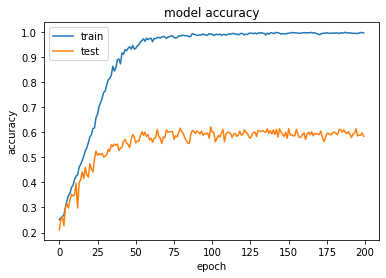

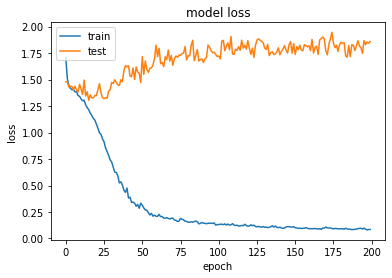

0.5756207674943566
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 991, 16)       176       
_________________________________________________________________
elu_1 (ELU)                  (None, 22, 991, 16)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 991, 16)       64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 991, 32)        10784     
_________________________________________________________________
elu_2 (ELU)                  (None, 2, 991, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2, 991, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None,

In [11]:
def CRNN(x_train,y_train,x_test,y_test):
    train_example = x_train
    test_example = x_test
    train_target = keras.utils.to_categorical(y_train, 4)
    test_target = keras.utils.to_categorical(y_test, 4)
    
    model = crnn(train_example[0].shape)
    model = train(model,train_example,train_target,test_example,test_target)
    acc = predict(model,test_example,test_target)
    print(acc)
    model.summary()
    return acc

acc = CRNN(x_train,y_train,x_test,y_test)